In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/emotions.zip

# *General Imports*

In [ ]:
import numpy as np 
import pandas as pd
import re
import os   
import random
import cv2
import shutil
from time import monotonic
from matplotlib import pyplot as plt 
from PIL import Image, ImageDraw

print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)

Numpy version: 1.21.6
Pandas version: 1.3.5


## CNN Model & Preprocessing Imports

In [ ]:
import keras
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K

import keras.layers as layers
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input, Dropout, Add
from keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Keras version: 2.9.0
GPU is available


Setting for global SEED 

In [ ]:
SEED = 77 #@param {type:"number"}

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(SEED)

## Import Datas

In [ ]:
BASE_PATH = "/content/emotions/" #@param {type:"string"}
TRAINING_PATH = "/content/emotions/train_class/" #@param {type:"string"}
TEST_PATH = "/content/emotions/val_class/" #@param {type:"string"}

BATCH_SIZE = 32 #@param {type:"number"}
IMAGE_SIZE = (299, 299) #@param ({type:"number",type:"number"})

emotion_classes = {0: 'anger',
                   1: 'contempt',
                   2: 'disgust',
                   3: 'fear',
                   4: 'happy',
                   5: 'neutral',
                   6: 'sad',
                   7: 'suprise'}

In [ ]:
def create_dataset(path):
    filenames_list = []
    categories_list = []
    i = 0
    for category in sorted(os.listdir(path)):
        if category == '.DS_Store':
            continue
        filenames = os.listdir(path + category)
        filenames_list = filenames_list  +  [files.replace(files, category + "/" + files) for files in filenames]
        categories_list = categories_list + [category] * len(filenames)
    df = pd.DataFrame({
        'filename': filenames_list,
        'emotion': categories_list
    })
    return df

df_train = create_dataset(TRAINING_PATH)
df_test = create_dataset(TEST_PATH,)
print('Training number of elements = ' , len(df_train))
print('Test number of elements = ' , len(df_test))

Training number of elements =  37278
Test number of elements =  3991


In [ ]:
df_train

,filename,emotion
0,anger/image0027523.jpg,anger
1,anger/image0028031.jpg,anger
2,anger/image0027565.jpg,anger
3,anger/image0030636.jpg,anger
4,anger/image0025610.jpg,anger
...,...,...
37273,surprise/image0002762.jpg,surprise
37274,surprise/image0031806.jpg,surprise
37275,surprise/image0033092.jpg,surprise
37276,surprise/image0022316.jpg,surprise


## Visualize Dataset Distribution

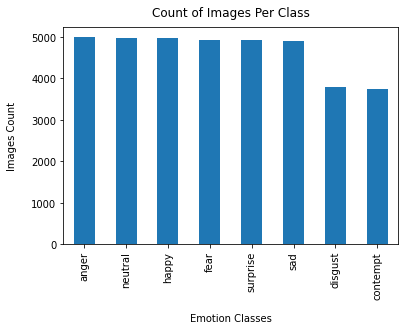

In [ ]:
def visualization_dataset(df):
  df_copy = df_train.copy()
  df_copy['emotion'] = df_copy['emotion'].apply(lambda x: x)
  df_copy['emotion'].value_counts().plot.bar(x = 'count', y = 'emotion')
  plt.style.use('seaborn-pastel')

  plt.xlabel("Emotion Classes", labelpad=14)
  plt.ylabel("Images Count", labelpad=14)
  plt.title("Count of Images Per Class", y=1.02)

visualization_dataset(df_train)

In [ ]:
print("Shape of dataframe before splitting {}".format(df_train.shape))

Shape of dataframe before splitting (37278, 2)


In [ ]:
df_train = df_train.groupby(["emotion"]) 
df_train = df_train.apply(lambda x: x.sample(df_train.size().min()).reset_index(drop=True))

df_train = df_train.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_train.shape))

Shape of balanced dataframe (30000, 2)


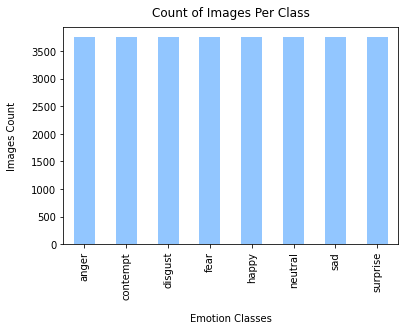

In [ ]:
visualization_dataset(df_train)

In [ ]:
df_train.describe()

,filename,emotion
count,30000,30000
unique,30000,8
top,anger/image0016776.jpg,anger
freq,1,3750


Split the df_train into two sets and then split the validate_df to two sets

In [ ]:
train_df, validate_df = train_test_split(df_train, test_size=0.2, random_state=SEED)

print('train size:', train_df.shape[0], 
      '| validate size:', validate_df.shape[0])

train size: 24000 | validate size: 6000


# Create Dataframe from images directory

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True)

train_ds = train_datagen.flow_from_dataframe(
    train_df, 
    TRAINING_PATH, 
    x_col='filename',
    y_col='emotion',
    target_size=IMAGE_SIZE,
    seed=SEED,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE)

Found 23996 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  n_invalid, x_col))


In [ ]:
validation_datagen = image.ImageDataGenerator(rescale=1./255)

validation_ds = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAINING_PATH, 
    x_col='filename',
    y_col='emotion',
    target_size=IMAGE_SIZE,
    seed=SEED,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE)

Found 5998 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  n_invalid, x_col))


Example Images 

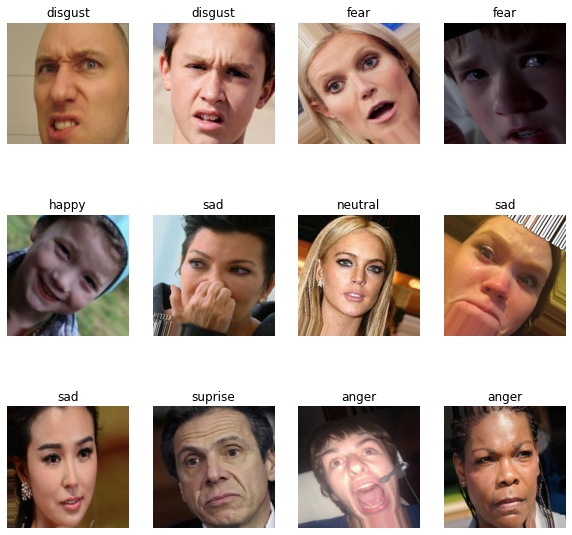

In [ ]:
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(emotion_classes[np.argmax(labels[i])])
    plt.axis("off")

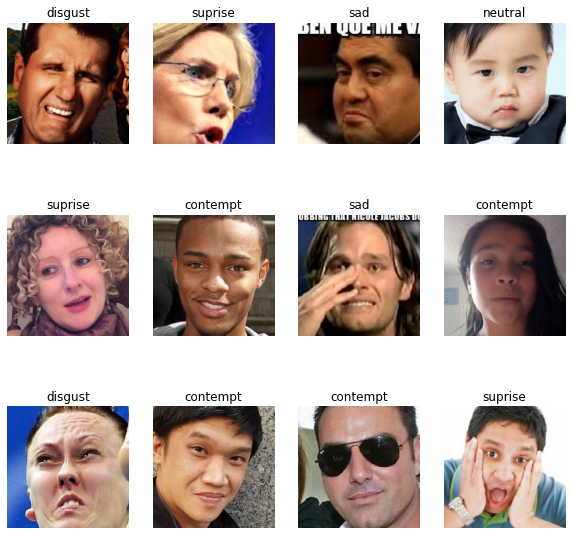

In [ ]:
images, labels = next(iter(validation_ds))
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(emotion_classes[np.argmax(labels[i])])
    plt.axis("off")

## Xception Model Architecture

In [ ]:
def separable_block(inputs, filters, prefix, relu_first=True):
    """ 
    Xception SeparableConv2D block 
        
    * Arguments
        inputs: Feature maps from previous block 
        filters: Number of filters for SeparableConv2D
        prefix: String for layer names

    * Returns
        out: Feature maps for next block 

    """

    if relu_first:   
        x = Activation('relu', name=prefix+'_ac')(inputs)
        x = SeparableConv2D(filters, (3, 3), padding='same', strides=(1, 1), use_bias=False, kernel_regularizer=l2(l2_reg), name=prefix)(x)
        out = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon, name=prefix+'_bn')(x)
    else:
        x = SeparableConv2D(filters, (3, 3), padding='same', strides=(1, 1), use_bias=False, kernel_regularizer=l2(l2_reg), name=prefix)(inputs)
        x = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon, name=prefix+'_bn')(x)
        out = Activation('relu', name=prefix+'_ac')(x)

    return out

In [ ]:
def xception_model(input_shape, classes, l2_reg=0.01):
    """
    Xception Model build function 

    * Arguments
        input_shape: 
        classes: Integer refer to number of given classes 
        l2_reg: Float. L2 regularization used in the convolutional blocks. 

    * Returns
        Tensorflow-Keras Model 

    """
    
    img_input = Input(input_shape, name='Input')
    
    ''' ----- ENRTY FLOW -----'''
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, kernel_regularizer=l2(l2_reg), name='block1_conv1')(img_input)
    x = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon, name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_ac')(x)
    x = Conv2D(64, (3, 3), use_bias=False, kernel_regularizer=l2(l2_reg), name='block1_conv2')(x)
    x = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon, name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_ac')(x)
    
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False, name='residual_1')(x)
    residual = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon)(residual)

    x = separable_block(x, 128, 'block2_conv1', relu_first=False)
    x = separable_block(x, 128, 'block2_conv2', relu_first=False)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False, name='residual_2')(x)
    residual = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon)(residual)
    
    x = separable_block(x, 256, 'block3_conv1', relu_first=True)
    x = separable_block(x, 256, 'block3_conv2', relu_first=True)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])
    
    residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False, name='residual_3')(x)
    residual = BatchNormalization(momentum=bn_momentum, epsilon=bn_epsilon)(residual)

    x = separable_block(x, 728, 'block4_conv1', relu_first=True)
    x = separable_block(x, 728, 'block4_conv2', relu_first=True)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    '''  ---- MIDDLE FLOW ----  '''
    for index in range(8):
          residual = x
          prefix = 'block' + str(index + 5) + '_conv' + str(index)

          x = separable_block(x, 728, prefix+'_conv1', relu_first=True)
          x = separable_block(x, 728, prefix+'_conv2', relu_first=True)
          x = separable_block(x, 728, prefix+'_conv3', relu_first=True)
          x = Add()([x, residual])
    
    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False, name='residual_4')(x)
    residual = BatchNormalization()(residual)

    ''' ----- EXIT FLOW ----- '''
    x = separable_block(x, 728, 'block13_conv1', relu_first=True)
    x = separable_block(x, 1024, 'block13_conv2', relu_first=True)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Add()([x, residual])

    x = separable_block(x, 1536, 'block14_conv1', relu_first=False)
    x = separable_block(x, 2048, 'block14_conv2', relu_first=False)

    ''' ----- FULLY CONNECTED LAYERS ----- '''
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(classes, activation='softmax', name='Output')(x)

    model = Model(img_input, output, name='Xception_Deep_C')
    return model

In [ ]:
input_shape=(299, 299, 3) #@param ({type:"number",type:"number",type:"number"})
num_classes=8 #@param {type:"number"}

l2_reg=0.01 #@param {type:"number"}

bn_momentum=0.99 #@param {type:"number"}
bn_epsilon=0.001 #@param {type:"number"}

xception = xception_model(input_shape, num_classes, l2_reg)

print(xception.inputs)
print(xception.outputs)

[<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'Input')>]
[<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'Output')>]


In [ ]:
xception.summary()

Model: "Xception_Deep_C"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                   

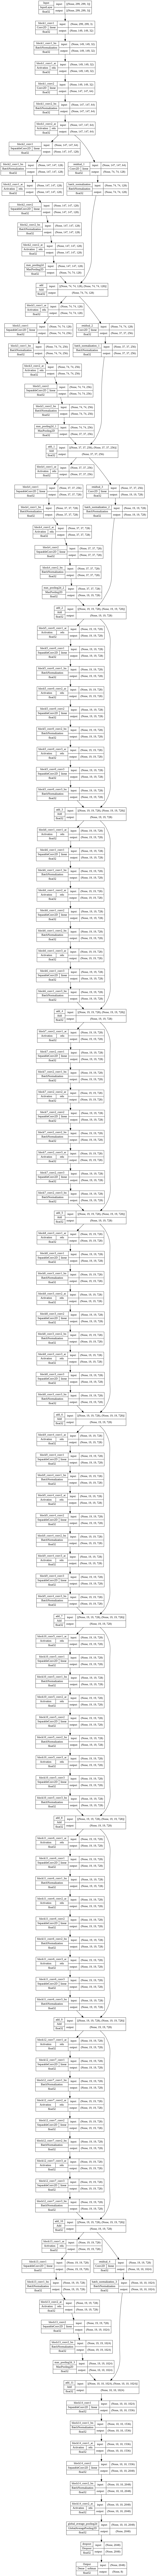

In [ ]:
tf.keras.utils.plot_model(xception, to_file='model.png', 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True )

# Train Xception Model 

Callbacks setting for Xception model 

In [ ]:
check_pointer = ModelCheckpoint(filepath=xception.name + '_weights.hdf5',
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1) 

Compile Model

In [ ]:
''' Adam Parameters '''
learning_rate=1e-4 #@param {type:"number"}

xception.compile(optimizer=Adam(learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Train Model




In [ ]:
epochs=100 #@param {type:"number"}
 
hist = xception.fit(train_ds, 
                    epochs=epochs,
                    validation_data=validation_ds,
                    callbacks=[check_pointer,early_stop,reduce_lr])

Epoch 1/100
750/750 [==============================] - 615s 800ms/step - loss: 2.4463 - accuracy: 0.1678 - val_loss: 2.3563 - val_accuracy: 0.1821 - lr: 1.0000e-04
Epoch 2/100
750/750 [==============================] - 595s 793ms/step - loss: 2.1329 - accuracy: 0.2688 - val_loss: 2.1483 - val_accuracy: 0.2836 - lr: 1.0000e-04
Epoch 3/100
750/750 [==============================] - 591s 788ms/step - loss: 1.9196 - accuracy: 0.3292 - val_loss: 2.6155 - val_accuracy: 0.2391 - lr: 1.0000e-04
Epoch 4/100
750/750 [==============================] - 592s 788ms/step - loss: 1.7543 - accuracy: 0.3856 - val_loss: 1.7671 - val_accuracy: 0.3781 - lr: 1.0000e-04
Epoch 5/100
750/750 [==============================] - 593s 790ms/step - loss: 1.6454 - accuracy: 0.4251 - val_loss: 1.6238 - val_accuracy: 0.4350 - lr: 1.0000e-04
Epoch 6/100
750/750 [==============================] - 593s 791ms/step - loss: 1.5587 - accuracy: 0.4522 - val_loss: 1.5504 - val_accuracy: 0.4498 - lr: 1.0000e-04
Epoch 7/100
750/

# Evaluate the Model 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


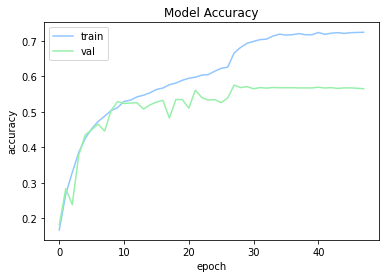

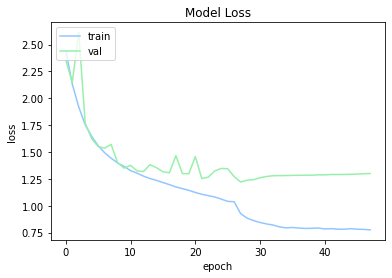

In [ ]:
print(hist.history.keys())
# Plot history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Plot history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss']) 
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    TEST_PATH, 
    x_col='filename',
    y_col='emotion',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE//2
)

Found 3989 validated image filenames belonging to 8 classes.


In [ ]:
eval_preds = xception.evaluate(test_generator)

In [ ]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
 
 _,cap_image = cap.read()

 cap_img_gray = cv2.cvtColor(cap_image, cv2.COLOR)

 faces = face_haar_cascade.detectMultiScale(cap_img_gray, 1.3, 5)

 for (x,y,w,h) in faces:

   cv2.rectangle(cap_image, (x,y), (x+w,y+h),(255,0,0),2)
   roi_gray = cap_img_gray[y:y+h, x:x+w]
   roi_gray = cv2.resize(roi_gray, (299, 299))
   img_pixels = image.img_to_array(roi_gray)
   img_pixels = np.expand_dims(img_pixels, axis=0)

   predictions = xception.predict(img_pixels)
   emotion_label = np.argmax(predictions)
   emotion_prediction = emotion_classes[emotion_label]

   cv2.putText(cap_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1 )
   resize_image = cv2.resize(cap_image, (1000,700))
   cv2.imshow('Emotion', resize_image)

   if cv2.waitKey(10) == ord('b'):
    break
  
cap.release()
cv2.destroyAllWindows